In [3]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from utils import observe_condition, observe_cell_types

adata = sc.read_h5ad("../nCoV_dataset_full.h5ad")
observe_condition(adata)
observe_cell_types(adata)

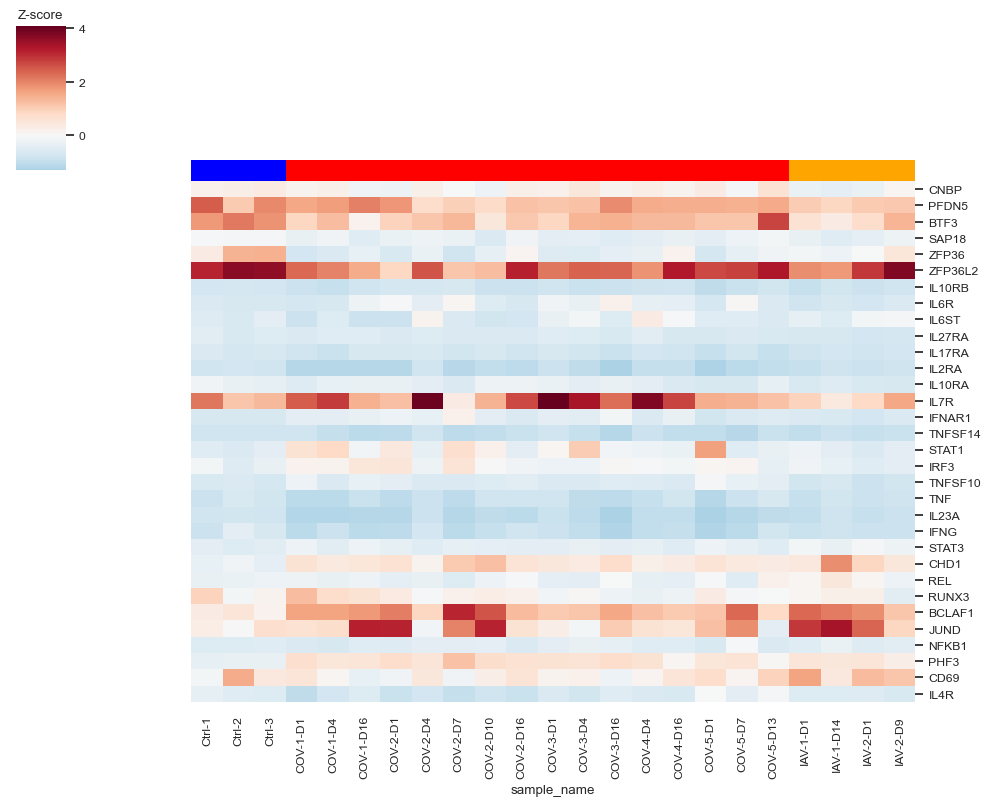

In [4]:
sample_order = [
    "Ctrl-1", "Ctrl-2", "Ctrl-3",
    "COV-1-D1", "COV-1-D4", "COV-1-D16",
    "COV-2-D1", "COV-2-D4", "COV-2-D7", "COV-2-D10", "COV-2-D16",
    "COV-3-D1", "COV-3-D4", "COV-3-D16",
    "COV-4-D4", "COV-4-D16",
    "COV-5-D1", "COV-5-D7", "COV-5-D13",
    "IAV-1-D1", "IAV-1-D14", "IAV-2-D1", "IAV-2-D9"
]

marker_genes = [
    "CNBP", "PFDN5", "BTF3", "SAP18", "ZFP36", "ZFP36L2", "IL10RB", "IL6R", "IL6ST",
    "IL27RA", "IL17RA", "IL2RA", "IL10RA", "IL7R", "IFNAR1", "TNFSF14", "STAT1", "IRF3",
    "TNFSF10", "TNF", "IL23A", "IFNG", "STAT3", "CHD1", "REL", "RUNX3", "BCLAF1", "JUND",
    "NFKB1", "PHF3", "CD69", "IL4R"
]

# === Map genes to indices ===
gene_to_index = {gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)}
gene_indices = [gene_to_index[g] for g in marker_genes]

# === Subset the data ===
adata_filtered = adata[adata.obs["sample_name"].isin(sample_order)].copy()

# === Extract raw expression matrix ===
X = adata_filtered.raw[:, gene_indices].X
X = X.toarray() if hasattr(X, "toarray") else X

df_expr = pd.DataFrame(X, columns=marker_genes)
df_expr["sample_name"] = adata_filtered.obs["sample_name"].values

# === Average expression per sample ===
avg_expr = df_expr.groupby("sample_name").mean().loc[sample_order]

# === Z-score genes across samples ===
scaler = StandardScaler()
z_scores = pd.DataFrame(
    scaler.fit_transform(avg_expr.T).T,
    index=avg_expr.index,
    columns=avg_expr.columns
).T

# === Create side color bar for sample groups ===
group_colors = []
for s in sample_order:
    if "Ctrl" in s:
        group_colors.append("blue")
    elif "COV" in s:
        group_colors.append("red")
    elif "IAV" in s:
        group_colors.append("orange")

# === Plot ===
sns.set(font_scale=0.8)
g = sns.clustermap(
    z_scores,
    cmap="RdBu_r",
    center=0,
    col_colors=group_colors,
    row_cluster=False,
    col_cluster=False,
    figsize=(10, 8)
)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
g.cax.set_title('Z-score')
plt.show()

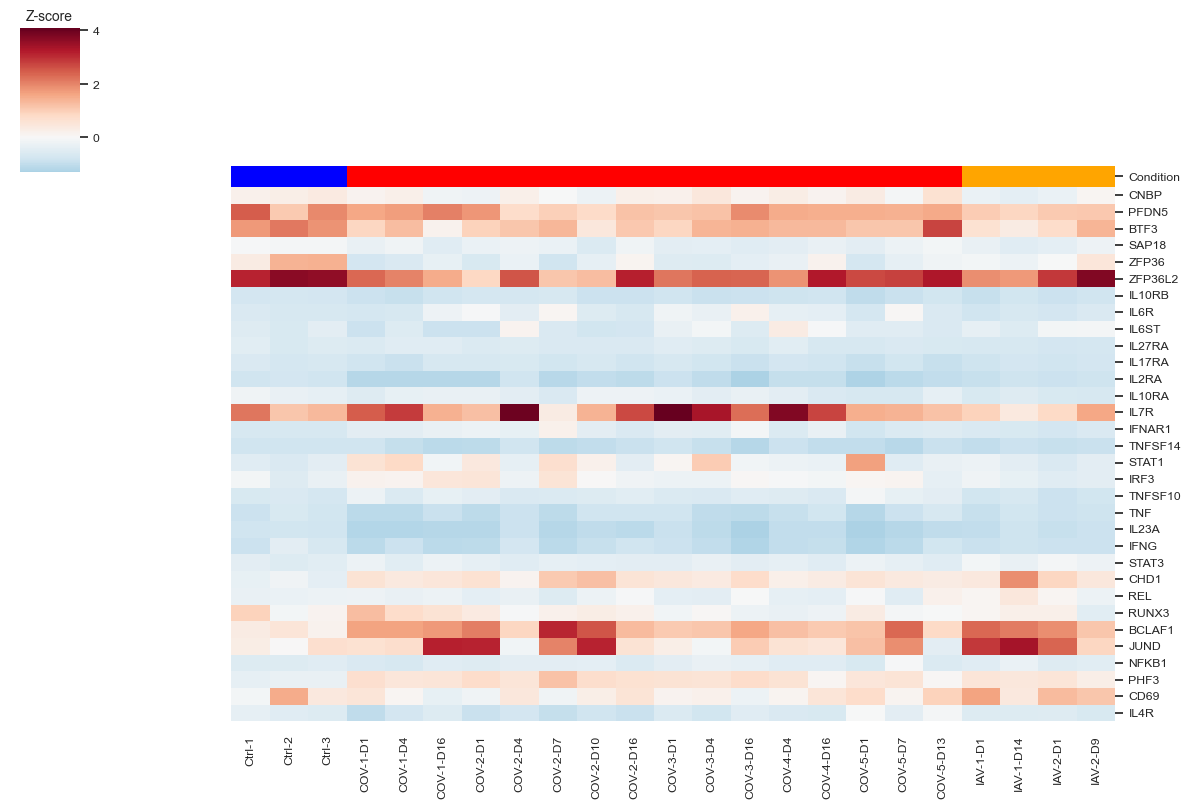

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# === Define sample and gene order from paper ===
sample_order = [
    "Ctrl-1", "Ctrl-2", "Ctrl-3",
    "COV-1-D1", "COV-1-D4", "COV-1-D16",
    "COV-2-D1", "COV-2-D4", "COV-2-D7", "COV-2-D10", "COV-2-D16",
    "COV-3-D1", "COV-3-D4", "COV-3-D16",
    "COV-4-D4", "COV-4-D16",
    "COV-5-D1", "COV-5-D7", "COV-5-D13",
    "IAV-1-D1", "IAV-1-D14", "IAV-2-D1", "IAV-2-D9"
]

marker_genes = [
    "CNBP", "PFDN5", "BTF3", "SAP18", "ZFP36", "ZFP36L2", "IL10RB", "IL6R", "IL6ST",
    "IL27RA", "IL17RA", "IL2RA", "IL10RA", "IL7R", "IFNAR1", "TNFSF14", "STAT1", "IRF3",
    "TNFSF10", "TNF", "IL23A", "IFNG", "STAT3", "CHD1", "REL", "RUNX3", "BCLAF1", "JUND",
    "NFKB1", "PHF3", "CD69", "IL4R"
]

# === Map genes to indices ===
gene_to_index = {gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)}
gene_indices = [gene_to_index[g] for g in marker_genes]

# === Subset adata ===
adata_filtered = adata[adata.obs["sample_name"].isin(sample_order)].copy()

# === Extract raw gene expression ===
X = adata_filtered.raw[:, gene_indices].X
X = X.toarray() if hasattr(X, "toarray") else X

df_expr = pd.DataFrame(X, columns=marker_genes)
df_expr["sample_name"] = adata_filtered.obs["sample_name"].values

# === Average expression per sample ===
avg_expr = df_expr.groupby("sample_name").mean().loc[sample_order]

# === Z-score across samples ===
scaler = StandardScaler()
z_scores = pd.DataFrame(
    scaler.fit_transform(avg_expr.T),
    index=marker_genes,
    columns=sample_order
)

# === Create side color bar (group colors) ===
group_colors = []
for s in sample_order:
    if "Ctrl" in s:
        group_colors.append("blue")
    elif "COV" in s:
        group_colors.append("red")
    elif "IAV" in s:
        group_colors.append("orange")

col_colors = pd.DataFrame(group_colors, index=sample_order, columns=["Condition"])

# === Plot ===
sns.set(font_scale=0.8)
g = sns.clustermap(
    z_scores,
    cmap="RdBu_r",
    center=0,
    col_colors=col_colors,
    row_cluster=False,
    col_cluster=False,
    figsize=(12, 8)
)

# Adjust ticks
g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(),
    rotation=90,
    ha='center'
)
g.ax_heatmap.set_yticklabels(
    g.ax_heatmap.get_yticklabels(),
    rotation=0,
    va='center'
)

# Fix colorbar title
g.cax.set_title('Z-score', fontsize=10)

plt.show()


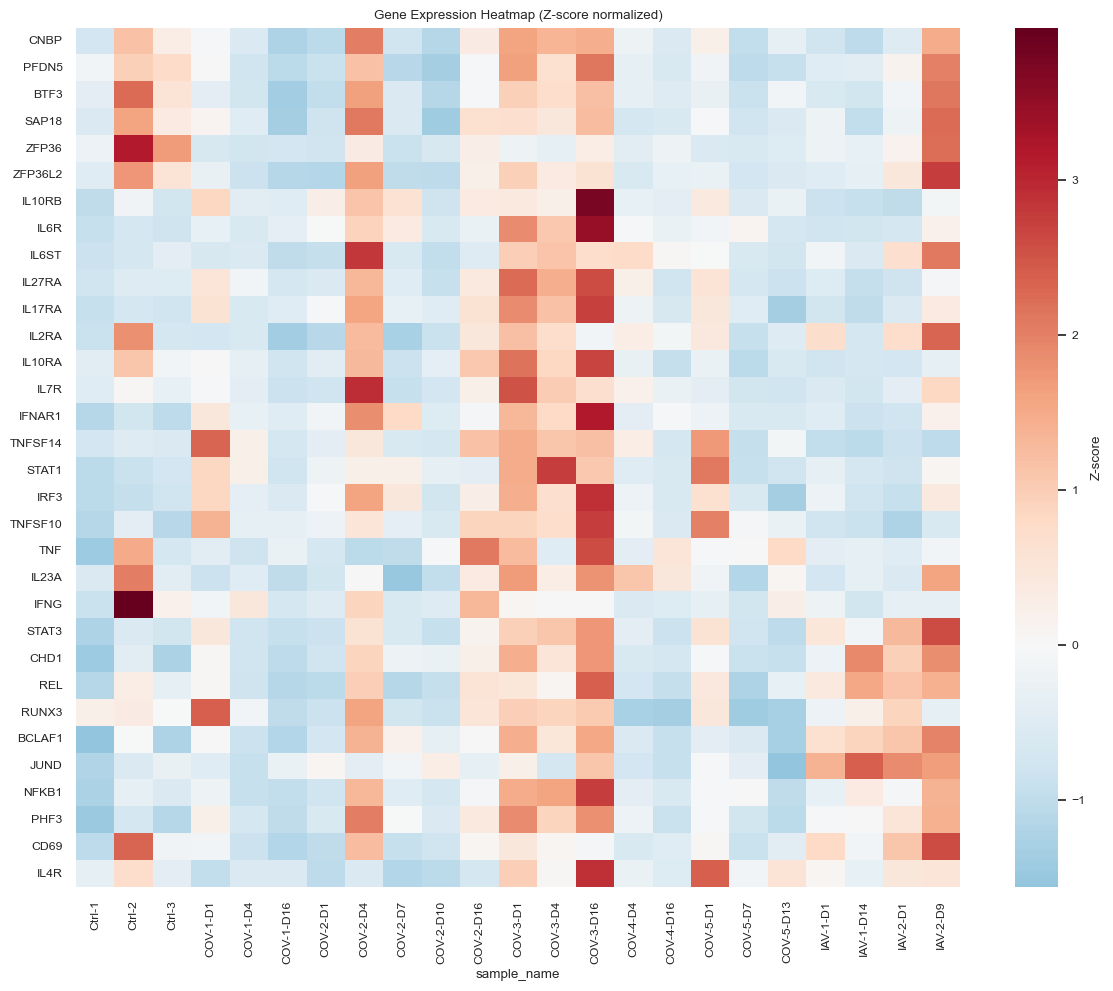

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# === Define gene list and sample order (from paper) ===
genes = [
    "CNBP", "PFDN5", "BTF3", "SAP18", "ZFP36", "ZFP36L2", "IL10RB", "IL6R", "IL6ST",
    "IL27RA", "IL17RA", "IL2RA", "IL10RA", "IL7R", "IFNAR1", "TNFSF14", "STAT1", "IRF3",
    "TNFSF10", "TNF", "IL23A", "IFNG", "STAT3", "CHD1", "REL", "RUNX3", "BCLAF1", "JUND",
    "NFKB1", "PHF3", "CD69", "IL4R"
]

gene_to_index = {
    gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)
}

# Convert your gene list to indices
gene_indices = [gene_to_index[gene] for gene in genes]

sample_order = [
    "Ctrl-1", "Ctrl-2", "Ctrl-3",
    "COV-1-D1", "COV-1-D4", "COV-1-D16",
    "COV-2-D1", "COV-2-D4", "COV-2-D7", "COV-2-D10", "COV-2-D16",
    "COV-3-D1", "COV-3-D4", "COV-3-D16",
    "COV-4-D4", "COV-4-D16",
    "COV-5-D1", "COV-5-D7", "COV-5-D13",
    "IAV-1-D1", "IAV-1-D14", "IAV-2-D1", "IAV-2-D9"
]

# === Extract gene expression and sample labels ===
adata_filtered = adata[adata.obs["sample_name"].isin(sample_order), :].copy()
X = adata_filtered.raw[:, gene_indices].X.toarray() if hasattr(adata_filtered.raw[:, gene_indices].X, "toarray") else adata_filtered.raw[:, genes].X
df = pd.DataFrame(X, columns=genes)
df["sample_name"] = adata_filtered.obs["sample_name"].values

# === Compute average expression per sample ===
avg_expr = df.groupby("sample_name").mean().loc[sample_order].T

# === Z-score each gene across samples ===
scaler = StandardScaler()
z_scores = pd.DataFrame(scaler.fit_transform(avg_expr.T).T, index=avg_expr.index, columns=avg_expr.columns)

# === Plot the heatmap ===
plt.figure(figsize=(12, 10))
sns.heatmap(z_scores, cmap="RdBu_r", center=0, xticklabels=True, yticklabels=True, cbar_kws={"label": "Z-score"})
plt.xticks(rotation=90)
plt.title("Gene Expression Heatmap (Z-score normalized)")
plt.tight_layout()
plt.show()


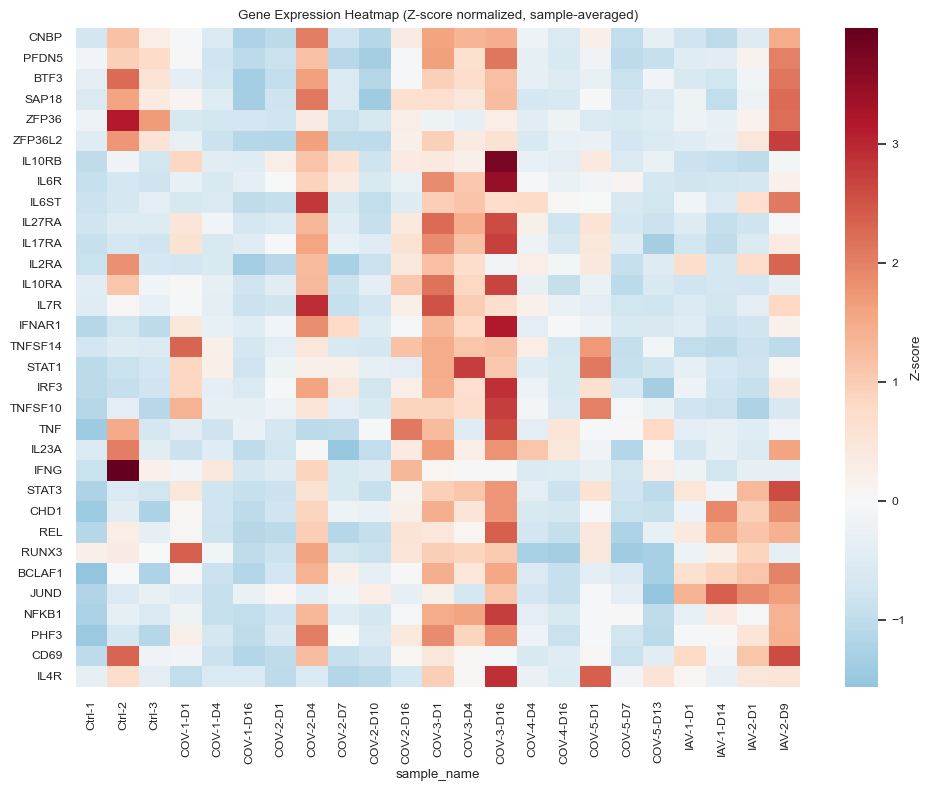

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define genes and sample order
genes = [
    "CNBP", "PFDN5", "BTF3", "SAP18", "ZFP36", "ZFP36L2", "IL10RB", "IL6R", "IL6ST",
    "IL27RA", "IL17RA", "IL2RA", "IL10RA", "IL7R", "IFNAR1", "TNFSF14", "STAT1", "IRF3",
    "TNFSF10", "TNF", "IL23A", "IFNG", "STAT3", "CHD1", "REL", "RUNX3", "BCLAF1", "JUND",
    "NFKB1", "PHF3", "CD69", "IL4R"
]

sample_order = [
    "Ctrl-1", "Ctrl-2", "Ctrl-3",
    "COV-1-D1", "COV-1-D4", "COV-1-D16",
    "COV-2-D1", "COV-2-D4", "COV-2-D7", "COV-2-D10", "COV-2-D16",
    "COV-3-D1", "COV-3-D4", "COV-3-D16",
    "COV-4-D4", "COV-4-D16",
    "COV-5-D1", "COV-5-D7", "COV-5-D13",
    "IAV-1-D1", "IAV-1-D14", "IAV-2-D1", "IAV-2-D9"
]

# Map genes to indices
gene_to_index = {gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)}
gene_indices = [gene_to_index[g] for g in genes]
# Subset the adata
adata_filtered = adata[adata.obs["sample_name"].isin(sample_order)].copy()

# Extract expression matrix for marker genes
X = adata_filtered.raw[:, gene_indices].X
X = X.toarray() if hasattr(X, "toarray") else X

# Build dataframe: one row per cell
df = pd.DataFrame(X, columns=genes)
df["sample_name"] = adata_filtered.obs["sample_name"].values

# Average gene expression per sample
avg_expr = df.groupby("sample_name").mean().loc[sample_order].T

# Z-score each gene across samples
scaler = StandardScaler()
z_scores = pd.DataFrame(
    scaler.fit_transform(avg_expr.T).T,
    index=avg_expr.index,
    columns=avg_expr.columns
)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    z_scores,
    cmap="RdBu_r",
    center=0,
    xticklabels=True,
    yticklabels=True,
    cbar_kws={"label": "Z-score"}
)
plt.xticks(rotation=90)
plt.title("Gene Expression Heatmap (Z-score normalized, sample-averaged)")
plt.tight_layout()
plt.show()


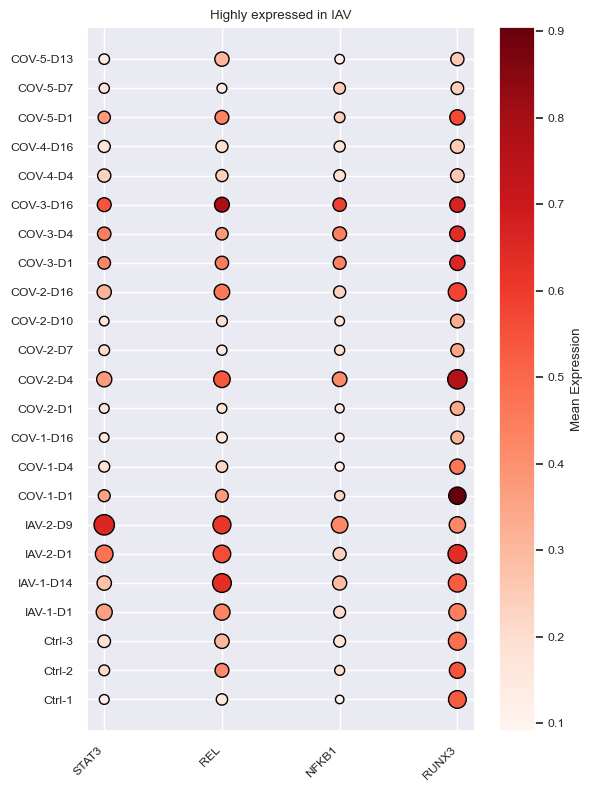

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define genes for "Highly expressed in IAV"
genes = ["STAT3", "REL", "NFKB1", "RUNX3"]

# Define sample order
sample_order = [
    "COV-5-D13", "COV-5-D7", "COV-5-D1",
    "COV-4-D16", "COV-4-D4",
    "COV-3-D16", "COV-3-D4", "COV-3-D1",
    "COV-2-D16", "COV-2-D10", "COV-2-D7", "COV-2-D4", "COV-2-D1",
    "COV-1-D16", "COV-1-D4", "COV-1-D1",
    "IAV-2-D9", "IAV-2-D1",
    "IAV-1-D14", "IAV-1-D1",
    "Ctrl-3", "Ctrl-2", "Ctrl-1"
]

# Map genes to indices
gene_to_index = {gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)}
gene_indices = [gene_to_index[g] for g in genes]

# Subset data
adata_filtered = adata[adata.obs["sample_name"].isin(sample_order)].copy()
X = adata_filtered.raw[:, gene_indices].X
X = X.toarray() if hasattr(X, "toarray") else X

# Build dataframe
df_expr = pd.DataFrame(X, columns=genes)
df_expr["sample_name"] = adata_filtered.obs["sample_name"].values

# Compute mean and % detected
plot_data = []
for sample in sample_order:
    subset = df_expr[df_expr["sample_name"] == sample]
    for gene in genes:
        mean_expr = subset[gene].mean()
        pct_expr = (subset[gene] > 0).sum() / subset.shape[0]
        plot_data.append({
            "sample": sample,
            "gene": gene,
            "mean_expr": mean_expr,
            "pct_expr": pct_expr
        })

plot_df = pd.DataFrame(plot_data)

# Plot
plt.figure(figsize=(6, 8))
scatter = plt.scatter(
    x=plot_df["gene"],
    y=plot_df["sample"],
    s=plot_df["pct_expr"] * 500,  # scale for visibility
    c=plot_df["mean_expr"],
    cmap="Reds",
    edgecolors="black"
)
plt.xticks(rotation=45, ha="right")
plt.gca().invert_yaxis()  # Top to bottom like the paper
cbar = plt.colorbar(scatter)
cbar.set_label("Mean Expression")
plt.title("Highly expressed in IAV")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define genes for "Highly expressed in IAV"
genes = ["STAT3", "REL", "NFKB1", "RUNX3"]

# Define genes for "Highly expressed in COV"
genes = ["IL6R", "IL6ST", "STAT1", "IRF3"]

# Define sample order
sample_order = [
    "COV-5-D13", "COV-5-D7", "COV-5-D1",
    "COV-4-D16", "COV-4-D4",
    "COV-3-D16", "COV-3-D4", "COV-3-D1",
    "COV-2-D16", "COV-2-D10", "COV-2-D7", "COV-2-D4", "COV-2-D1",
    "COV-1-D16", "COV-1-D4", "COV-1-D1",
    "IAV-2-D9", "IAV-2-D1",
    "IAV-1-D14", "IAV-1-D1",
    "Ctrl-3", "Ctrl-2", "Ctrl-1"
]

# Map genes to indices
gene_to_index = {gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)}
gene_indices = [gene_to_index[g] for g in genes]

# Subset data
adata_filtered = adata[adata.obs["sample_name"].isin(sample_order)].copy()
X = adata_filtered.raw[:, gene_indices].X
X = X.toarray() if hasattr(X, "toarray") else X

# Build dataframe
df_expr = pd.DataFrame(X, columns=genes)
df_expr["sample_name"] = adata_filtered.obs["sample_name"].values

# Compute mean and % detected
plot_data = []
for sample in sample_order:
    subset = df_expr[df_expr["sample_name"] == sample]
    for gene in genes:
        mean_expr = subset[gene].mean()
        pct_expr = (subset[gene] > 0).sum() / subset.shape[0]
        plot_data.append({
            "sample": sample,
            "gene": gene,
            "mean_expr": mean_expr,
            "pct_expr": pct_expr
        })

plot_df = pd.DataFrame(plot_data)

# Plot
plt.figure(figsize=(6, 8))
scatter = plt.scatter(
    x=plot_df["gene"],
    y=plot_df["sample"],
    s=plot_df["pct_expr"] * 500,  # scale for visibility
    c=plot_df["mean_expr"],
    cmap="Reds",
    edgecolors="black"
)
plt.xticks(rotation=45, ha="right")
plt.gca().invert_yaxis()  # Top to bottom like the paper
cbar = plt.colorbar(scatter)
cbar.set_label("Mean Expression")
plt.title("Highly expressed in COV")
plt.tight_layout()
plt.show()
